In [1]:
import pyrealsense2 as rs

camera_width = 1280
camera_height = 720

# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, camera_width, camera_height, rs.format.z16, 30)
config.enable_stream(rs.stream.color, camera_width, camera_height, rs.format.rgb8, 30)
profile = pipeline.start(config)
depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
align_to = rs.stream.color
align = rs.align(align_to)

In [2]:
import cupy as cp

In [3]:
import jetson.inference
net = jetson.inference.detectNet('facenet-120', 0.5)

jetson.inference.__init__.py


In [4]:
def center_crop(img, new_width=720, new_height=720):
    width = img.shape[1]
    height = img.shape[0]

    if new_width is None:
        new_width = min(width, height)

    if new_height is None:
        new_height = min(width, height)

    left = int(cp.ceil((width - new_width) / 2))
    right = width - int(cp.floor((width - new_width) / 2))

    top = int(cp.ceil((height - new_height) / 2))
    bottom = height - int(cp.floor((height - new_height) / 2))

    if len(img.shape) == 2:
        center_cropped_img = img[top:bottom, left:right]
    else:
        center_cropped_img = img[top:bottom, left:right, ...]

    return center_cropped_img

In [5]:
#import numpy as np
import jetson.utils
import cv2
#from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

test_img_name = "test.jpg"

def processImage(image, width=450, height=450):
    global test_img_name
    
    # input frame has shape 720x1280x3 [RGB]
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
    ax1.set_title("RAW image from cam:" + str(image.shape), fontsize=10)
    ax1.imshow(image)
    
    # make center crop
    frame = center_crop(image)
    ax2.set_title("center crop:" + str(frame.shape), fontsize=10)
    ax2.imshow(frame)
    
    # to RGBA
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2RGBA)
    ax3.set_title("RGBA:" + str(frame.shape), fontsize=10)
    ax3.imshow(frame)
    
    # resize
    frame = cv2.resize(frame, (width, height))
    ax4.set_title("resized:" + str(frame.shape), fontsize=10)
    ax4.imshow(frame)
    
    # reshape to 4 x width x height
    frame = frame.transpose(2, 1, 0)
    
    # change to float in range 0.0 - 255.0
    frame = frame * 1.0
    
    # jetson.utils.cudaDeviceSynchronize()
    
    frame_gpu = jetson.utils.cudaFromNumpy(frame)
    #print(frame_gpu)
    jetson.utils.saveImageRGBA(test_img_name, frame_gpu, width, height)
    
    return frame_gpu

jetson.utils.__init__.py


read frame


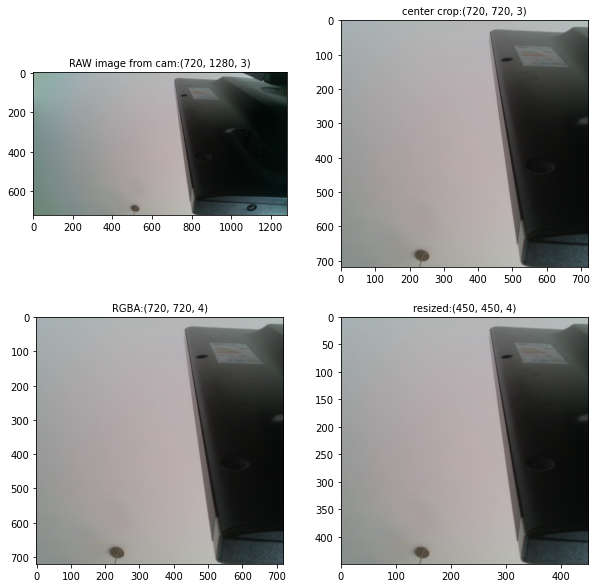

In [6]:
# load config params
#from settings import Config
import matplotlib.pyplot as plt
import numpy as np

#config = Config.get_instance()

reps = 1
color_image = None
frame_gpu = None
detections = None

width = 450
height = 450

# skip first 5 frames
for _ in range(0, 5):
    frames = pipeline.wait_for_frames()
    depth_frame = frames.get_depth_frame()
    color_frame = frames.get_color_frame()

for _ in range(0, reps):
    print('read frame')
    frames = pipeline.wait_for_frames()
    depth_frame = frames.get_depth_frame()
    color_frame = frames.get_color_frame()
    
    color_image = np.asanyarray(color_frame.get_data())
    
    frame_gpu = processImage(color_image)
    
    # print(frame_gpu)
    detections = net.Detect(frame_gpu, width, height)
    
    net.PrintProfilerTimes()

In [7]:
print(detections)

[]


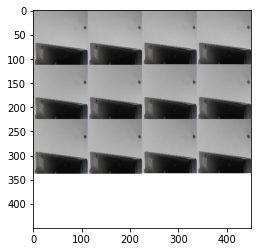

In [8]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

image = mpimg.imread(test_img_name)
plt.imshow(image)

In [9]:
# stop threading
if pipeline != None:
    pipeline.stop()